# Week 5: I’m Something of a Painter Myself
### In this mini project, I build a machine learning model that brings artist's style to your photos or recreate the style from scratch!
###  
### This notebook consists of the table of contents below.
#### 1. description of the data
#### 2. exploratory data analysis (EDA)
#### 3. model building and training
#### 4. result
#### 5. conclusion

### 1. Description of the Data

+ The dataset contains 300 Monet's paints and 7,028 photos.
+ These images are 256x256 size JPG and TFRecord format.

### 2. Exploratory Data Analysis (EDA)
EDA is not necessarily required in this project, but it is conducted at the level of simply checking the data.
### Data preparation

In [134]:
# Load packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import math

from PIL import Image

import matplotlib.pyplot as plt

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')

device = torch.device("cuda" if cuda else "cpu")

cuda: True


#### Visualize Photos from dataset

In [119]:
def visualize_images(path, n_images, x_label, figsize=(16, 16)):
    plt.figure(figsize=figsize)
    w = int(n_images ** 0.5)
    h = math.ceil(n_images / w)
    
    all_names = os.listdir(path)
    image_names = all_names[:n_images]   
            
    for ind, image_name in enumerate(image_names):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.subplot(w, h, ind + 1)
        plt.imshow(img)
        plt.xlabel(f"{x_label}_{ind+1}")
        plt.xticks([])
        plt.yticks([])
    
    plt.show()

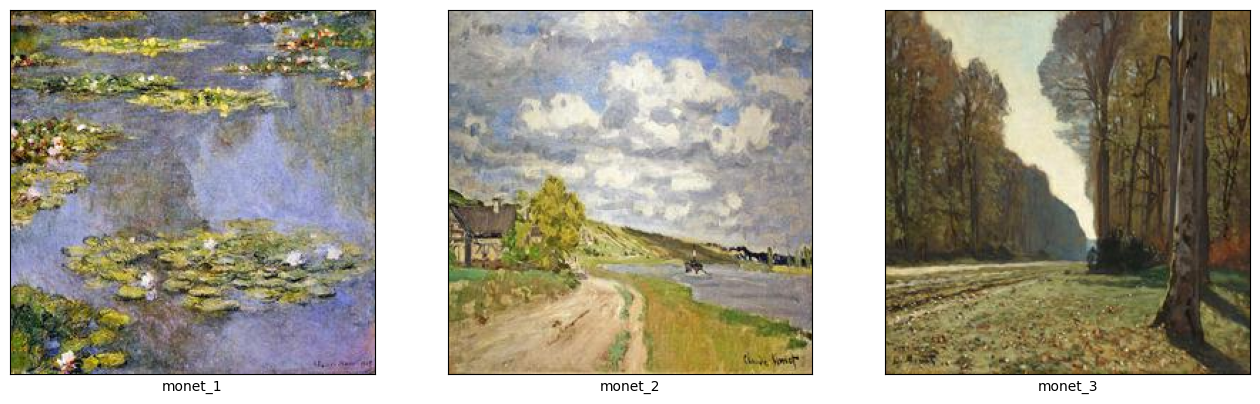

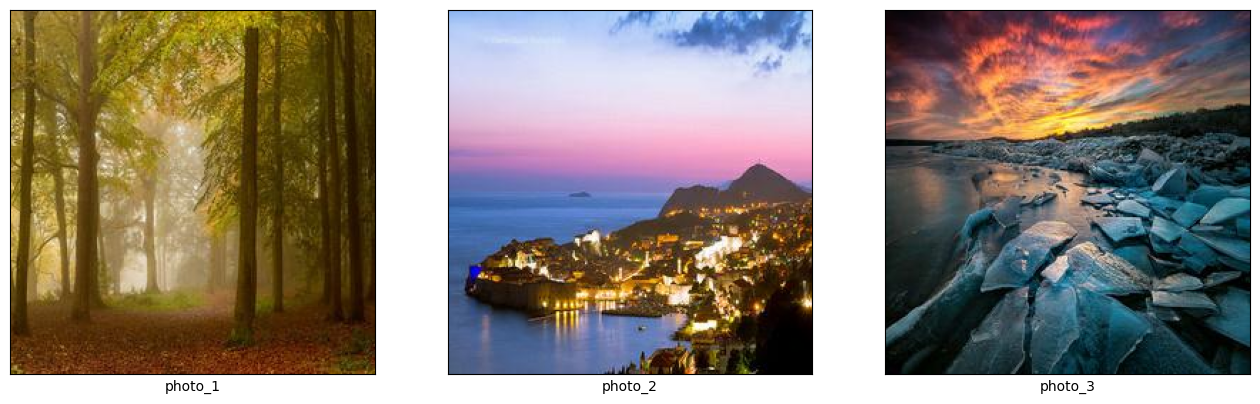

In [120]:
root_dir = '/kaggle/input/gan-getting-started/'

visualize_images(os.path.join(root_dir, 'monet_jpg'), 3, "monet")
visualize_images(os.path.join(root_dir, 'photo_jpg'), 3, "photo")

#### RGB Histogram

In [121]:
def show_color_histogram(path):
    image_names = os.listdir(path)
    image_name = np.random.choice(image_names)
    img = cv2.imread(os.path.join(path, image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    ax1.imshow(img)
    
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        ax2.plot(histr,color = col)
        ax2.axis(xmin=0, xmax=256)

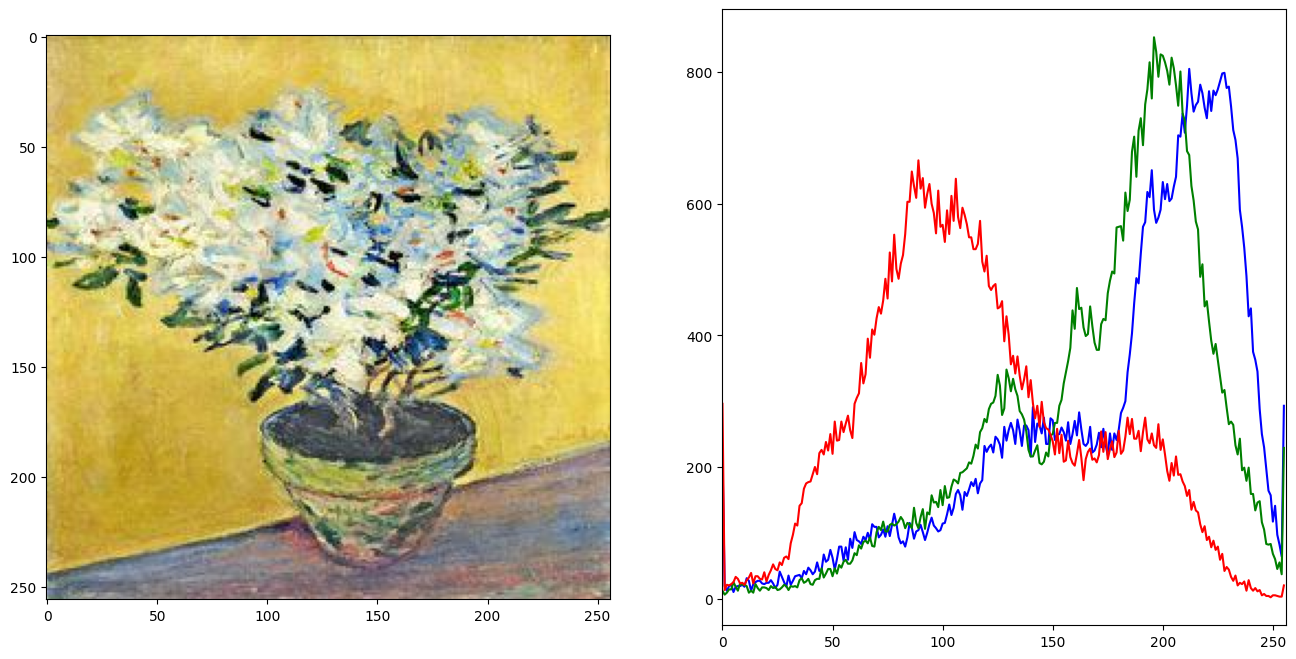

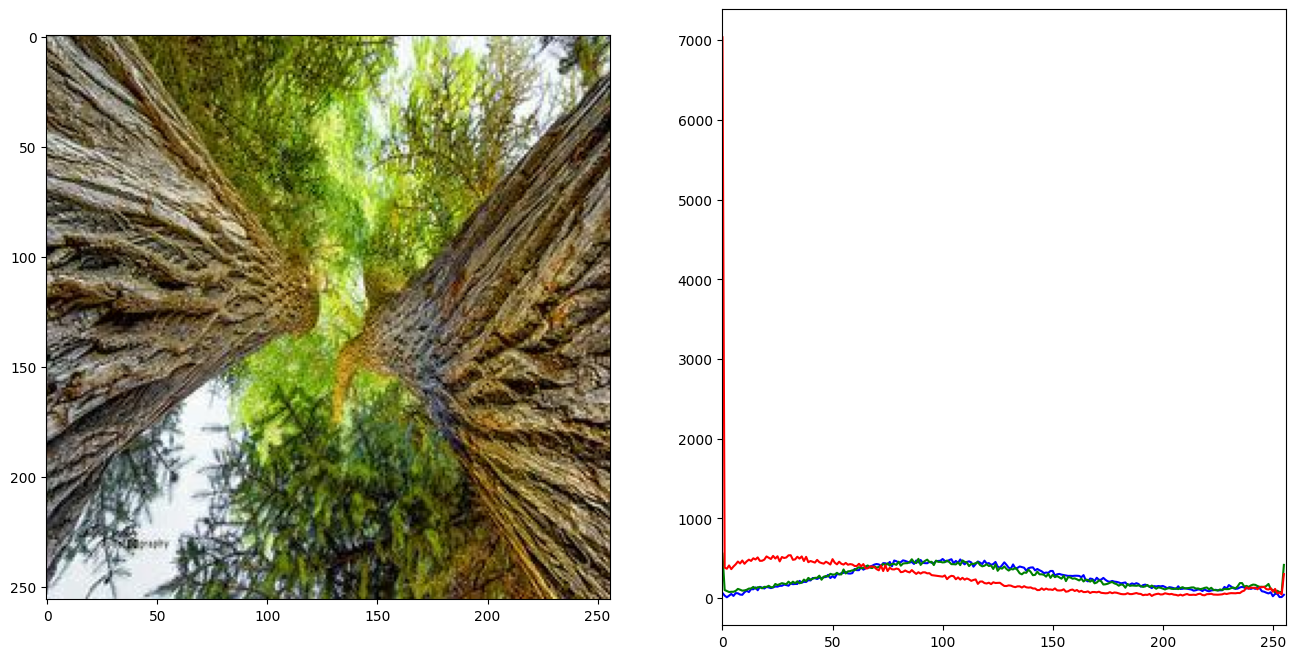

In [122]:
show_color_histogram(os.path.join(root_dir, 'monet_jpg'))
show_color_histogram(os.path.join(root_dir, 'photo_jpg'))

### Load Dataset

In [123]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, mode='train', transforms=None):
        A_dir = os.path.join(data_dir, 'monet_jpg')
        B_dir = os.path.join(data_dir, 'photo_jpg')
        
        if mode == 'train':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[:250]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[:250]]
        elif mode == 'test':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[250:]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[250:301]]
        
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files_A)
    
    def __getitem__(self, index):
        file_A = self.files_A[index]
        file_B = self.files_B[index]
        
        img_A = Image.open(file_A)
        img_B = Image.open(file_B)
        
        if self.transforms is not None:
            img_A = self.transforms(img_A)
            img_B = self.transforms(img_B)
        
        return img_A, img_B

In [124]:
transforms_ = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 5

trainloader = DataLoader(
    ImageDataset(root_dir, mode='train', transforms=transforms_),
    batch_size = batch_size,
    shuffle = True,
    num_workers = 3
)

testloader = DataLoader(
    ImageDataset(root_dir, mode='test', transforms=transforms_),
    batch_size = batch_size,
    shuffle = False,
    num_workers = 3
)

### 3. Model building and training
### Build CycleGAN model


A. Build Generator architecture

In [125]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

In [126]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        
        # Inital Convolution  3*256*256 -> 64*256*256
        out_channels=64
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, out_channels, 2*in_channels+1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
        channels = out_channels
        
        # Downsampling   64*256*256 -> 128*128*128 -> 256*64*64
        self.down = []
        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)
        
        # Transformation (ResNet)  256*64*64
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)
        
        # Upsampling  256*64*64 -> 128*128*128 -> 64*256*256
        self.up = []
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor=2), # bilinear interpolation
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)
        
        # Out layer  64*256*256 -> 3*256*256
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x

B. Build Discriminator architecture

In [127]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # why normalize=False?
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32
            *self.block(256, 512), # 256*32*32 -> 512*16*16
            
            # Why padding first then convolution?
            nn.ZeroPad2d((1,0,1,0)), # padding left and top   512*16*16 -> 512*17*17
            nn.Conv2d(512, 1, 4, padding=1) # 512*17*17 -> 1*16*16
        )
        
        self.scale_factor = 16
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, x):
        return self.model(x)

#### Model training

In [128]:
# Initialize models

G_AB = GeneratorResNet(3, num_residual_blocks=9)
D_B = Discriminator(3)

G_BA = GeneratorResNet(3, num_residual_blocks=9)
D_A = Discriminator(3)

In [129]:
# Loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

In [130]:
# Cuda Setting

if cuda:
    G_AB = G_AB.cuda()
    D_B = D_B.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    
    criterion_GAN = criterion_GAN.cuda()
    criterion_cycle = criterion_cycle.cuda()
    criterion_identity = criterion_identity.cuda()

In [131]:
# Define optimizers

import itertools
lr = 0.0005
b1 = 0.5
b2 = 0.996

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1, b2)
)

optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1, b2)
)

In [137]:
# Learning Rate Scheduler Setting

n_epoches = 10
decay_epoch = 2

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)

In [138]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

for epoch in range(n_epoches):
    for i, (real_A, real_B) in enumerate(trainloader):
        real_A, real_B = real_A.type(Tensor), real_B.type(Tensor)
        
        # groud truth
        out_shape = [real_A.size(0), 1, real_A.size(2)//D_A.scale_factor, real_A.size(3)//D_A.scale_factor]
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)
        
        """Train Generators"""
        # set to training mode in the begining, beacause sample_images will set it to eval mode
        G_AB.train()
        G_BA.train()
        
        optimizer_G.zero_grad()
        
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        
        # identity loss
        loss_id_A = criterion_identity(fake_B, real_A)
        loss_id_B = criterion_identity(fake_A, real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss, train G to make D think it's true
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) 
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # G totol loss
        loss_G = 5.0*loss_identity + loss_GAN + 10.0*loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        """Train Discriminator A"""
        optimizer_D_A.zero_grad()
        
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        
        loss_D_A.backward()
        optimizer_D_A.step()
        
        """Train Discriminator B"""
        optimizer_D_B.zero_grad()
        
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        
        loss_D_B.backward()
        optimizer_D_B.step()
    
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    loss_D = (loss_D_A + loss_D_B) / 2
    print(f'[Epoch {epoch+1}/{n_epoches}]')
    print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
    print(f'[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item()}]')  

[Epoch 1/10]
[G loss: 5.229401588439941 | identity: 0.3046281635761261 GAN: 0.3319651484489441 cycle: 0.33742958307266235]
[D loss: 0.20351767539978027 | D_A: 0.19488880038261414 D_B: 0.2121465653181076]
[Epoch 2/10]
[G loss: 4.630997657775879 | identity: 0.2864573299884796 GAN: 0.42440706491470337 cycle: 0.27743038535118103]
[D loss: 0.1967962682247162 | D_A: 0.23981021344661713 D_B: 0.15378233790397644]
[Epoch 3/10]
[G loss: 4.336003303527832 | identity: 0.2382316291332245 GAN: 0.6267780065536499 cycle: 0.25180667638778687]
[D loss: 0.16360948979854584 | D_A: 0.17022080719470978 D_B: 0.1569981724023819]
[Epoch 4/10]
[G loss: 4.7771687507629395 | identity: 0.25575870275497437 GAN: 1.0412341356277466 cycle: 0.24571408331394196]
[D loss: 0.17021900415420532 | D_A: 0.26158633828163147 D_B: 0.07885165512561798]
[Epoch 5/10]
[G loss: 4.069607734680176 | identity: 0.24269162118434906 GAN: 0.6736569404602051 cycle: 0.21824929118156433]
[D loss: 0.06779328733682632 | D_A: 0.04720691218972206 

### 4. Result
#### Generate and Save Images

In [139]:
photo_dir = os.path.join(root_dir, 'photo_jpg')
files = [os.path.join(photo_dir, name) for name in os.listdir(photo_dir)]
len(files)

7038

In [140]:
save_dir = '../images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [141]:
generate_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

to_image = transforms.ToPILImage()

G_BA.eval()
for i in range(0, len(files), batch_size):
    # read images
    imgs = []
    for j in range(i, min(len(files), i+batch_size)):
        img = Image.open(files[j])
        img = generate_transforms(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).type(Tensor)
    
    # generate
    fake_imgs = G_BA(imgs).detach().cpu()
    
    # save
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)
        
        img = to_image(img_arr)
        _, name = os.path.split(files[i+j])
        img.save(os.path.join(save_dir, name))

In [143]:
import shutil
shutil.make_archive('/kaggle/working/images', 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

### 5. Conclusion

In this project, I constructed the model by using CycleGAN. U-Net and ResNet are used in many models for CycleGAN architecture. So, I used Resnet in my project. Computing power was used a lot, so the number of epochs was minimized, which did not result in good results. However, constructing the model has given us a better understanding of adversarial learning in GANs.
<br>

##### Additional Considerations
1. Data augmentation - Need to leverage Domain knowledge on
2. Proper hyperparameters settings
3. Better architecture configuration
4. More Epoches